# Cloud Workshop Azure Databricks
## 09. AutoML

<img src="https://raw.githubusercontent.com/retkowsky/images/master/AzureDatabricksLogo.jpg"><br>
V1.3 12/06/2019

In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

In this notebook you will learn how to:
1. Create Azure Machine Learning Workspace object and initialize your notebook directory to easily reload this object from a configuration file.
2. Create an `Experiment` in an existing `Workspace`.
3. Configure AutoML using `AutoMLConfig`.
4. Train the model using Azure Databricks.
5. Explore the results.
6. Test the best fitted model.

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/how-to-automated-ml/automated-machine-learning.png">
<br>
> https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml

## Problématique :

<img src="https://raw.githubusercontent.com/retkowsky/images/master/digits%20ML.jpg">
<br>

In [5]:
import azureml.core

# Check core SDK version number - based on build number of preview/master.
print("Version Azure ML service :", azureml.core.VERSION)

username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user').split("@")[0]
print("Your username is {0}".format(username))

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (cryptography 1.5 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('cryptography>=2.5'), {'paramiko'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core:PipelineRun._from_dto with exception (cryptography 1.5 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('cryptography>=2.5'), {'paramiko'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.StepRun = azureml.pipeline.core:StepRun._from_dto with exception (cryptography 1.5 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('cryptography>=2.5'), {'paramiko'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core:StepRun._from_reused_dto with exception (cryptography 1.5 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('cryptography>=2.5'), {'paramiko'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (cryptography 1.5 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('cryptography>=2.5'), {'paramiko'}).
Version Azure ML service : 1.0.43
Your username is seretkow

## 1. Create an Experiment

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [7]:
import logging
import os
import random
import time

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Connexion workspace Azure ML service

In [9]:
subscription_id = "A RENSEIGNER" #you should be owner or contributor
resource_group = "azuremlserviceresourcegroup" #you should be owner or contributor
workspace_name = "azuremlservice" #your workspace name
workspace_region = "West Europe" #your region

In [10]:
# Import the Workspace class and check the Azure ML SDK version.
from azureml.core import Workspace

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,                      
                      exist_ok=True)

from azureml.core import Workspace

In [11]:
ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config(path="/databricks/", file_name="config.json")

In [12]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'workshop_automl'
project_folder = './worshop/automl_classification'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Out[ 6 ]: 
 
Experiment Name workshop_automl 
Location westeurope 
Project Directory ./worshop/automl_classification
Resource Group azuremlserviceresourcegroup 
SDK version 1.0.43 
Workspace Name azuremlservice

## 3. Diagnostics

Opt-in diagnostics for better experience, quality, and security of future releases.

In [14]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on.

## 4. Load Training Data Using DataPrep

In [16]:
import azureml.dataprep as dprep

# You can use `auto_read_file` which intelligently figures out delimiters and datatypes of a file.
# The data referenced here was pulled from `sklearn.datasets.load_digits()`.
simple_example_data_root = 'https://dprepdata.blob.core.windows.net/automl-notebook-data/'
X_train = dprep.auto_read_file(simple_example_data_root + 'X.csv').skip(1)  # Remove the header row.

# You can also use `read_csv` and `to_*` transformations to read (with overridable delimiter)
# and convert column types manually.
# Here we read a comma delimited file and convert all columns to integers.
y_train = dprep.read_csv(simple_example_data_root + 'y.csv').to_long(dprep.ColumnSelector(term='.*', use_regex = True))

## Review the Data Preparation Result
You can peek the result of a Dataflow at any range using skip(i) and head(j). Doing so evaluates only j records for all the steps in the Dataflow, which makes it fast even against large datasets.

In [18]:
X_train.skip(1).head(10)

Out[ 9 ]: 
 Column1 Column2 Column3 ... Column62 Column63 Column64
0 0 0 0 ... 10 0 0 
1 0 0 0 ... 16 9 0 
2 0 0 7 ... 9 0 0 
3 0 0 0 ... 4 0 0 
4 0 0 12 ... 10 0 0 
5 0 0 0 ... 11 3 0 
6 0 0 7 ... 0 0 0 
7 0 0 9 ... 11 1 0 
8 0 0 11 ... 3 0 0 
9 0 0 1 ... 3 0 0 

[10 rows x 64 columns]

## 5. Configure AutoML

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**spark_context**|Spark Context object. for Databricks, use spark_context=sc|
|**max_concurrent_iterations**|Maximum number of iterations to execute in parallel. This should be <= number of worker nodes in your Azure Databricks cluster.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|
|**exit_score**|Target score for your experiment. It is associated with the metric.|

> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

In [21]:
automl_config = AutoMLConfig(task = 'classification', # Type de l'automl
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted', # Métrique de choix des modèles
                             iteration_timeout_minutes = 5, # Timeout
                             iterations = 30, # Nombre itérations
                             n_cross_validations = 5, # Validation croisée
                             max_concurrent_iterations = 2, # A modifier en fonction du nombre de nodes du cluster Spark
                             verbosity = logging.INFO,
                             spark_context=sc, #databricks/spark 
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

## 6. Exécution AUTOML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console. If you are running a lot of iterations, you can set it to `False` and visualize in the portal.

In [23]:
local_run = experiment.submit(automl_config, show_output = True)

Running on ADB cluster experiment workshop_automl.
Parent Run ID: AutoML_7b80fa3b-7d0e-4ef5-ac5a-617ea9a778f5
****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION PIPELINE DURATION METRIC BEST
 1 StandardScalerWrapper SGD 0:00:13 0.9970 0.9970
 0 StandardScalerWrapper SGD 0:00:10 0.9943 0.9970
 2 MinMaxScaler LightGBM 0:00:07 0.9979 0.9979
 4 StandardScalerWrapper ExtremeRandomTrees 0:00:07 0.9966 0.9979
 3 StandardScalerWrapper SGD 0:00:07 0.9889 0.9979
 5 StandardScalerWrapper LightGBM 0:00:09 0.9979 0.9979
 7 MinMaxScaler RandomForest 0:00:08 0.9851 0.9979
 6 StandardScalerWrapper SGD 0:00:06 0.9960 0.9979
 8 StandardScalerWrapper SGD 0:00:06 0.9832 0.9979
 9 MinMaxScaler SGD 0:00:14 0.9964 0.9979
 10 MinMaxScaler RandomForest 0:00:13 0.9819 0.9979
 11 MaxAbsScaler LightGBM 0:00:08 0.9916 0.9979
 13 MinMaxScaler ExtremeRandomTrees 0:00:08 0.9676 0.9979
 12 MinMaxScaler LightGBM 0:00:11 0.9986 0.9986
 15 StandardScalerWrapper BernoulliNaiveBayes 0:00:05 0.9825 0.9986
 14 MinMaxScaler LightGBM 0:00:07 0.9917 0.9986
 16 StandardScalerWrapper LogisticRegression 0:00:08 0.9968 0.9986
 18 RobustScaler LightGBM 0:00:11 0.9983 0.9986
 17 StandardScalerWrapper SVM 0:00:16 0.9995 0.9995
 19 MaxAbsScaler LinearSVM 0:00:10 0.9980 0.9995
 20 MaxAbsScaler SVM 0:00:24 0.0183 0.9995
 21 StandardScalerWrapper SVM 0:00:20 0.9995 0.9995
 23 MaxAbsScaler LogisticRegression 0:00:09 0.9991 0.9995
 24 StandardScalerWrapper ExtremeRandomTrees 0:00:11 0.9967 0.9995
 22 MaxAbsScaler LinearSVM 0:00:21 0.9978 0.9995
 26 RobustScaler LogisticRegression 0:00:14 0.9977 0.9995
 25 RobustScaler SVM 0:00:11 0.9995 0.9995
 27 TruncatedSVDWrapper LogisticRegression 0:00:16 0.9963 0.9995
 28 VotingEnsemble 0:00:37 0.9999 0.9999
 29 StackEnsemble 0:00:43 0.9995 0.9999

## 7. Explore the Results

In [25]:
displayHTML("<a href={} target='_blank'>Lien AutoML portail Azure : {}</a>".format(local_run.get_portal_url(), local_run.id))

Lien AutoML portail Azure : AutoML_7b80fa3b-7d0e-4ef5-ac5a-617ea9a778f5

### Exemples :
<img src="https://raw.githubusercontent.com/retkowsky/images/master/Result1.jpg">
<br>
<br>
<img src="https://raw.githubusercontent.com/retkowsky/images/master/Result2.jpg">

#### Retrieve All Child Runs after the experiment has COMPLETED.
You can also use SDK methods to fetch all the child runs and see individual metrics that we log. This can take some time.

In [28]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}    
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

Out[ 15 ]: 
 0 1 2 3 ... 26 27 28 29
AUC_macro 0.99 1.00 1.00 0.99 ... 1.00 1.00 1.00 1.00
AUC_micro 0.99 1.00 1.00 0.99 ... 1.00 0.99 1.00 1.00
AUC_weighted 0.99 1.00 1.00 0.99 ... 1.00 1.00 1.00 1.00
accuracy 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96
average_precision_score_macro 0.98 0.99 0.99 0.94 ... 0.99 0.97 1.00 1.00
average_precision_score_micro 0.98 0.99 0.99 0.93 ... 0.99 0.96 1.00 0.99
average_precision_score_weighted 0.98 0.99 0.99 0.94 ... 0.99 0.97 1.00 1.00
balanced_accuracy 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.97
f1_score_macro 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96
f1_score_micro 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96
f1_score_weighted 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96
log_loss 0.55 0.23 0.31 1.63 ... 0.19 0.63 0.65 0.49
norm_macro_recall 0.95 0.96 0.94 0.90 ... 0.96 0.93 0.99 0.96
precision_score_macro 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.95
precision_score_micro 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96
precision_score_weighted 0.96 0.96 0.95 0.91 ... 0.96 0.94 0.99 0.95
recall_score_macro 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.97
recall_score_micro 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96
recall_score_weighted 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96
weighted_accuracy 0.95 0.96 0.94 0.91 ... 0.96 0.94 0.99 0.96

[20 rows x 30 columns]

## Best Model

In [30]:
best_run, fitted_model = local_run.get_output()

print(best_run)
print()
print(fitted_model)

Run(Experiment: workshop_automl,
Id: AutoML_7b80fa3b-7d0e-4ef5-ac5a-617ea9a778f5_28,
Type: None,
Status: Completed)

Pipeline(memory=None,
 steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
 estimators=[('25', Pipeline(memory=None,
 steps=[('RobustScaler', RobustScaler(copy=True, quantile_range=[10, 90], with_centering=True,
 with_scaling=True)), ('SVCWrapper', SVC...6666666666, 0.066666666666666666, 0.13333333333333333, 0.066666666666666666, 0.26666666666666666]))])

#### Best Model Based on Any Other Metric after the above run is complete based on the child run
Show the run and the model that has the smallest `accuracy` value:

> https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml

In [33]:
lookup_metric = "accuracy"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print()
print(fitted_model)

Run(Experiment: workshop_automl,
Id: AutoML_7b80fa3b-7d0e-4ef5-ac5a-617ea9a778f5_28,
Type: None,
Status: Completed)

Pipeline(memory=None,
 steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
 estimators=[('25', Pipeline(memory=None,
 steps=[('RobustScaler', RobustScaler(copy=True, quantile_range=[10, 90], with_centering=True,
 with_scaling=True)), ('SVCWrapper', SVC...6666666666, 0.066666666666666666, 0.13333333333333333, 0.066666666666666666, 0.26666666666666666]))])

### 8. Test the Best Fitted Model

#### Load Test Data - you can split the dataset beforehand & pass Train dataset to AutoML and use Test dataset to evaluate the best model.

In [35]:
from sklearn import datasets
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

#### Testing Our Best Fitted Model
We will try to predict digits and see how our model works. This is just an example to show you.

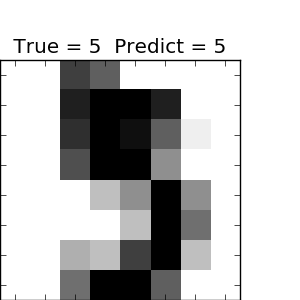

In [37]:
# Randomly select digits and test.

for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = " True = %d  Predict = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    display(fig)

> Fin